! /usr/local/anaconda3/envs/numpy_env/bin/python -m pip install little_mallet_wrapper


In [1]:
import tomotopy as tp
import little_mallet_wrapper
import seaborn
import glob
from pathlib import Path
import pandas as pd
import spacy
import matplotlib.pyplot as plt


In [2]:
directory = "../../2_Preprocessing/Corpus_deepseek_cleaned/"

In [3]:
files = glob.glob(f"{directory}/*.txt")

In [4]:
training_data = []
original_texts = []
titles = []

for file in files:
    text = open(file, encoding='utf-8').read()
    processed_text = little_mallet_wrapper.process_string(text, numbers='remove')
    training_data.append(processed_text)
    original_texts.append(text)
    titles.append(Path(file).stem)
print(titles[:10])


['What_is_DeepSeek,_the_Chinese_AI_startup_that_shoo', 'Chinese_AI_disrupter_DeepSeek_claims_top_spot_in_U', 'Which_countries_have_banned_DeepSeek_and_why?', 'Global_AI_rivalry_is_a_dangerous_game', 'DeepSeek_just_blew_up_the_AI_industry’s_narrative_', 'OpenAI_Says_DeepSeek_May_Have_Improperly_Harvested', 'They_Invested_Billions._Then_the_A.I._Script_Got_F', 'AI_giants_Baidu,_OpenAI_offer_their_chatbots_for_f', 'DeepSeek_banned_from_Australian_government_devices', 'DeepSeek_AI_shakes_American_swagger_and_upends_ass']


In [5]:
len(training_data), len(original_texts), len(titles)

(115, 115, 115)

Train Topic Modelling

In [6]:
# --- 1. Define your custom stopwords ---
custom_stopwords = set([
    'deepseek', 'china', 'chinese', 'say', 'also', 'one', 'new', 'would', 'could', 'use','openai',
])

# --- 2. Load SpaCy for lemmatization (optional but recommended) ---
nlp = spacy.load("en_core_web_sm")

def preprocess(text):
    """
    Tokenizes, lowercases, removes stopwords, keeps only alphabetic tokens, and lemmatizes.
    """
    doc = nlp(text.lower())
    return [token.lemma_ for token in doc if token.is_alpha and token.text not in custom_stopwords]

# --- 3. Preprocess all documents ---
cleaned_training_data = [preprocess(text) for text in training_data]

# --- 4. Initialize the LDA model ---
num_topics = 3
num_topic_words = 10
model = tp.LDAModel(k=num_topics)

# --- 5. Add preprocessed documents ---
for doc in cleaned_training_data:
    model.add_doc(doc)

# --- 6. Train the model ---
print("Topic Model Training...\n")
iterations = 10
for i in range(0, 100, iterations):
    model.train(iterations)
    print(f'Iteration: {i}\tLog-likelihood: {model.ll_per_word}')

# --- 7. Print topic results ---
print("\nTopic Model Results:\n")
topics = []
topic_individual_words = []

for topic_number in range(num_topics):
    topic_words = ' '.join(word for word, prob in model.get_topic_words(topic_id=topic_number, top_n=num_topic_words))
    topics.append(topic_words)
    topic_individual_words.append(topic_words.split())
    print(f"✨Topic {topic_number}✨\n{topic_words}\n")


Topic Model Training...

Iteration: 0	Log-likelihood: -8.409479680771161
Iteration: 10	Log-likelihood: -8.224468932671972
Iteration: 20	Log-likelihood: -8.148671599377241
Iteration: 30	Log-likelihood: -8.123467357989545
Iteration: 40	Log-likelihood: -8.099549817288286
Iteration: 50	Log-likelihood: -8.090364906141323
Iteration: 60	Log-likelihood: -8.080289812749598
Iteration: 70	Log-likelihood: -8.080479651127114
Iteration: 80	Log-likelihood: -8.076999937988145
Iteration: 90	Log-likelihood: -8.072314187106704

Topic Model Results:

✨Topic 0✨
model company tech technology market cost chip year like call

✨Topic 1✨
app chatgpt government chatbot question google datum information include user

✨Topic 2✨
firm train make claim think give research liang chip compute



Topic Model Results:

✨Topic 0✨
technology market nvidia intelligence trump may stock power take datum

✨Topic 1✨
model company tech make cost year like industry chip firm

✨Topic 2✨
app government chatgpt chatbot question people information include user ban

In [7]:
#  Here do manual topic labeling, which is a standard step after running LDA (or any topic model).
# Why we do this
# LDA gives us lists of words per topic, but these lists are not human-friendly.
# A human interprets the top words and assigns a short descriptive label.
#This makes visualizations (like heatmap) much clearer.

manual_labels = [
    "Technology & AI Trends",     # Topic 0
    "Companies & Economy",        # Topic 1
    "Politics & Government"       # Topic 2
]


In [8]:
# Load topic distributions
topic_distributions = [list(doc.get_topic_dist()) for doc in model.docs]

Make functions for displaying top documents. The get_top_docs() function is taken from Maria Antoniak’s Little Mallet Wrapper

In [74]:
from IPython.display import Markdown, display
import re

def make_md(string):
    display(Markdown(str(string)))

def get_top_docs(docs, topic_distributions, topic_index, n=5):
    
    sorted_data = sorted([(_distribution[topic_index], _document) 
                          for _distribution, _document 
                          in zip(topic_distributions, docs)], reverse=True)
    
    topic_words = topics[topic_index]
    
    make_md(f"### ✨Topic {topic_index}✨\n\n{topic_words}\n\n")
    print("---")
    
    for probability, doc in sorted_data[:n]:
        # Make topic words bolded
        for word in topic_words.split():
            if word in doc.lower():
                doc = re.sub(f"\\b{word}\\b", f"**{word}**", doc, re.IGNORECASE)
        
        make_md(f'✨  \n**Topic Probability**: {probability}  \n**Document**: {doc}\n\n')
    
    return

In [22]:
# display topic titles
get_top_docs(titles, topic_distributions, topic_index=0, n=6)

### ✨Topic 0✨

app datum government chatbot question people chatgpt information include user



---


✨  
**Topic Probability**: 0.7542241811752319  
**Document**: DeepSeek:_South_Korea_temporarily_bans_AI_app_–_DW



✨  
**Topic Probability**: 0.7055186629295349  
**Document**: South_Korea_bans_new_downloads_of_China's_DeepSeek



✨  
**Topic Probability**: 0.6664435863494873  
**Document**: What_questions_will_China's_DeepSeek_not_answer?_–



✨  
**Topic Probability**: 0.6410927176475525  
**Document**: DeepSeek_'shared_user_data'_with_TikTok_owner_Byte



✨  
**Topic Probability**: 0.6297187805175781  
**Document**: Which_countries_have_banned_DeepSeek_and_why?



✨  
**Topic Probability**: 0.6068841218948364  
**Document**: We_tried_out_DeepSeek._It_worked_well,_until_we_as



In [24]:
get_top_docs(titles, topic_distributions, topic_index=1, n=5)

### ✨Topic 1✨

model company tech chip market make nvidia cost year call



---


✨  
**Topic Probability**: 0.7106282114982605  
**Document**: DeepSeek’s_tech_breakthrough_hailed_in_China_as_an



✨  
**Topic Probability**: 0.674758791923523  
**Document**: US_tech_stocks_plunge_on_China_AI’s_unexpectedly_s



✨  
**Topic Probability**: 0.6725882291793823  
**Document**: A_shocking_Chinese_AI_advancement_called_DeepSeek_



✨  
**Topic Probability**: 0.6609187722206116  
**Document**: Chinese_start-up_DeepSeek_launches_AI_model_that_o



✨  
**Topic Probability**: 0.6579195261001587  
**Document**: DeepSeek:_What_lies_under_the_bonnet_of_the_new_AI



In [76]:
# Output CSV File
import pandas as pd

# Create a DataFrame with document titles and topic distributions
topic_results = []
for title, topic_distribution in zip(titles, topic_distributions):
    topic_results.append({'document': title, 'topic_distribution': topic_distribution})

df = pd.DataFrame(topic_results)

# Assign manual labels to columns
# Each column represents the probability of a topic in that document
df[manual_labels] = pd.DataFrame(df['topic_distribution'].tolist(), index=df.index)

# Drop the original 'topic_distribution' column
df = df.drop('topic_distribution', axis='columns')

df

,document,Technology & AI Trends,Companies & Economy,Politics & Government
0,"What_is_DeepSeek,_the_Chinese_AI_startup_that_...",0.117249,0.649011,0.233740
1,Chinese_AI_disrupter_DeepSeek_claims_top_spot_...,0.319994,0.481689,0.198316
2,Which_countries_have_banned_DeepSeek_and_why?,0.629719,0.232364,0.137918
3,Global_AI_rivalry_is_a_dangerous_game,0.178135,0.315668,0.506198
4,DeepSeek_just_blew_up_the_AI_industry’s_narrat...,0.124597,0.581106,0.294297
...,...,...,...,...
110,US_tech_stocks_partly_recover_after_Trump_says...,0.190850,0.519481,0.289670
111,Diving_into_DeepSeek:_inside_the_7_February_Gu...,0.365303,0.283088,0.351610
112,Hong_Kong_stocks_gain_on_valuation_focus_as_De...,0.183519,0.603310,0.213171
113,Nvidia_and_Microsoft_shares_steady_after_DeepS...,0.262032,0.514564,0.223404


In [36]:
# Save to CSV
df.to_csv("../output/topic_results.csv", index=False, encoding="utf-8")


Choose a topic from the results above and write down its corresponding topic number below.

Topic: Technology & AI Trends


In [37]:
df.sort_values(by='Technology & AI Trends', ascending=False)[:6]

,document,Technology & AI Trends,Companies & Economy,Politics & Government
74,DeepSeek_blocked_from_some_app_stores_in_Italy...,0.743535,0.085850,0.170615
8,DeepSeek_banned_from_Australian_government_dev...,0.679981,0.213594,0.106424
85,DeepSeek:_South_Korea_temporarily_bans_AI_app_...,0.666257,0.136314,0.197429
2,Which_countries_have_banned_DeepSeek_and_why?,0.623653,0.131011,0.245336
17,South_Korea_bans_new_downloads_of_China's_Deep...,0.612828,0.132057,0.255114
34,OpenAI_‘reviewing’_allegations_that_its_AI_mod...,0.598538,0.079680,0.321782


Explore Heatmap of Topics and Texts
We can visualize and compare these topic probability distributions with a heatmap by using the little_mallet_wrapper.plot_categories_by_topics_heatmap() function.

We need a list of target_labels, the sample of texts that we’d like to visualize and compare with the heatmap. Below we make our list of desired target labels.

In [26]:
target_labels = ["US_tech_stocks_plunge_on_China_AI’s_unexpectedly_s",
                 "Hong_Kong_stocks_gain_on_valuation_focus_as_DeepSe",
                 "A_shocking_Chinese_AI_advancement_called_DeepSeek_",
                 "China’s_DeepSeek_causes_rout_among_AI-linked_stock",
                 "DeepSeek_breakthrough,_Nvidia_stock_rout_raise_con",
                 "My_Take_|_Chinese_start-up_DeepSeek_looks_set_to_r"
]

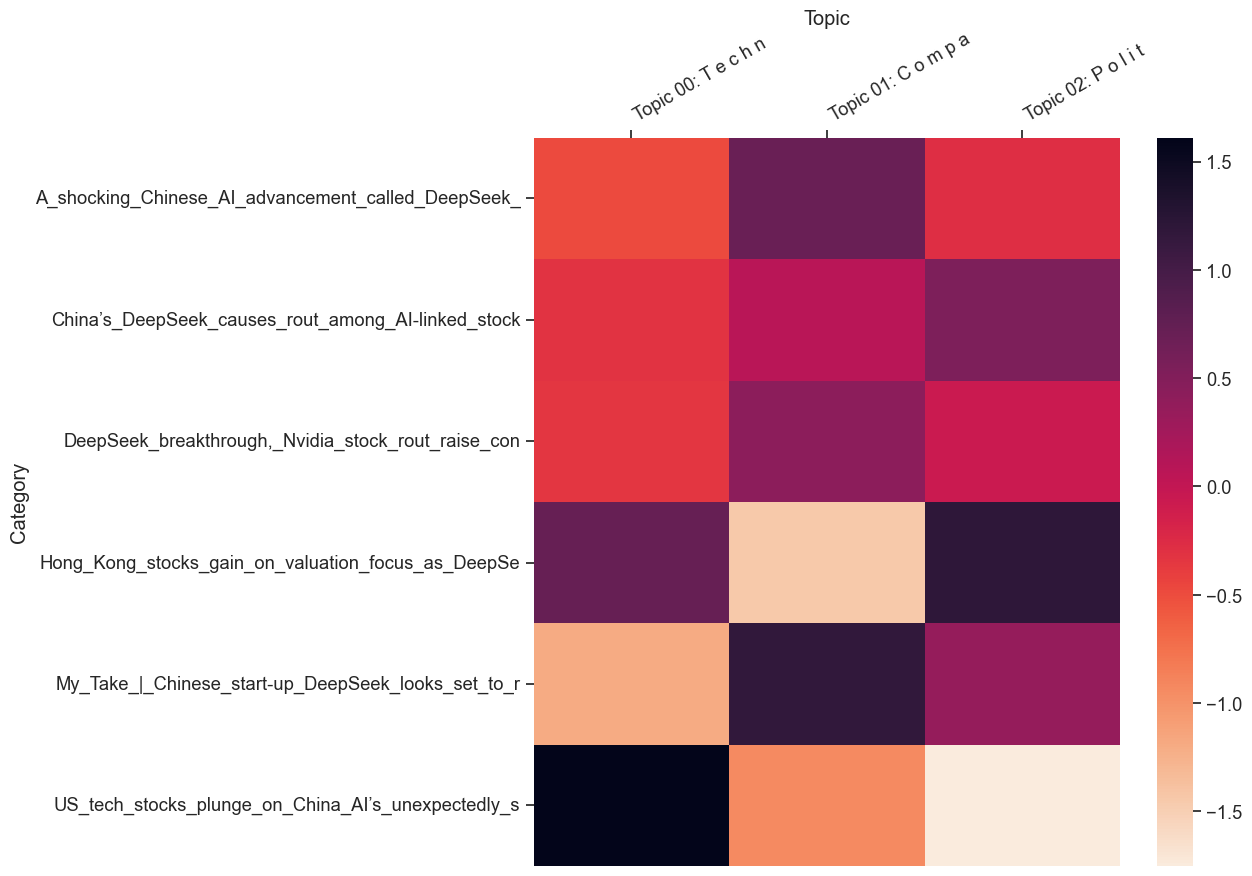

In [39]:

# Plot the heatmap
little_mallet_wrapper.plot_categories_by_topics_heatmap(
    titles,
    topic_distributions,
    manual_labels,
    target_labels=target_labels,
    dim=(13, 9)
)

# Get the current figure and axes
fig = plt.gcf()
ax = plt.gca()


plt.close(fig)


In [78]:
# We will build a list of negative texts.
corpus_path = "../../5_Sentiment_Analysis/negative_DeepSeek_texts"

# Generate target_labels automatically from filenames (without extension)
target_labels = [os.path.splitext(fname)[0] for fname in os.listdir(corpus_path)]
target_labels

['Global_AI_rivalry_is_a_dangerous_game',
 "What_questions_will_China's_DeepSeek_not_answer?_–",
 "DeepSeek:_Is_China's_AI_tool_as_good_as_it_seems?",
 'First_Thing:_Donald_Trump_calls_China’s_DeepSeek_A',
 'South_Korea_Bans_Downloads_of_DeepSeek,_the_Chines',
 'DeepSeek’s_tech_breakthrough_hailed_in_China_as_an',
 'DeepSeek_has_ripped_away_AI’s_veil_of_mystique._Th',
 'DeepSeek:_South_Korea_temporarily_bans_AI_app_–_DW',
 'South_Korea_removes_DeepSeek_from_app_stores_pendi',
 'US_tech_stocks_plunge_on_China_AI’s_unexpectedly_s',
 'Diving_into_DeepSeek:_inside_the_7_February_Guardi']

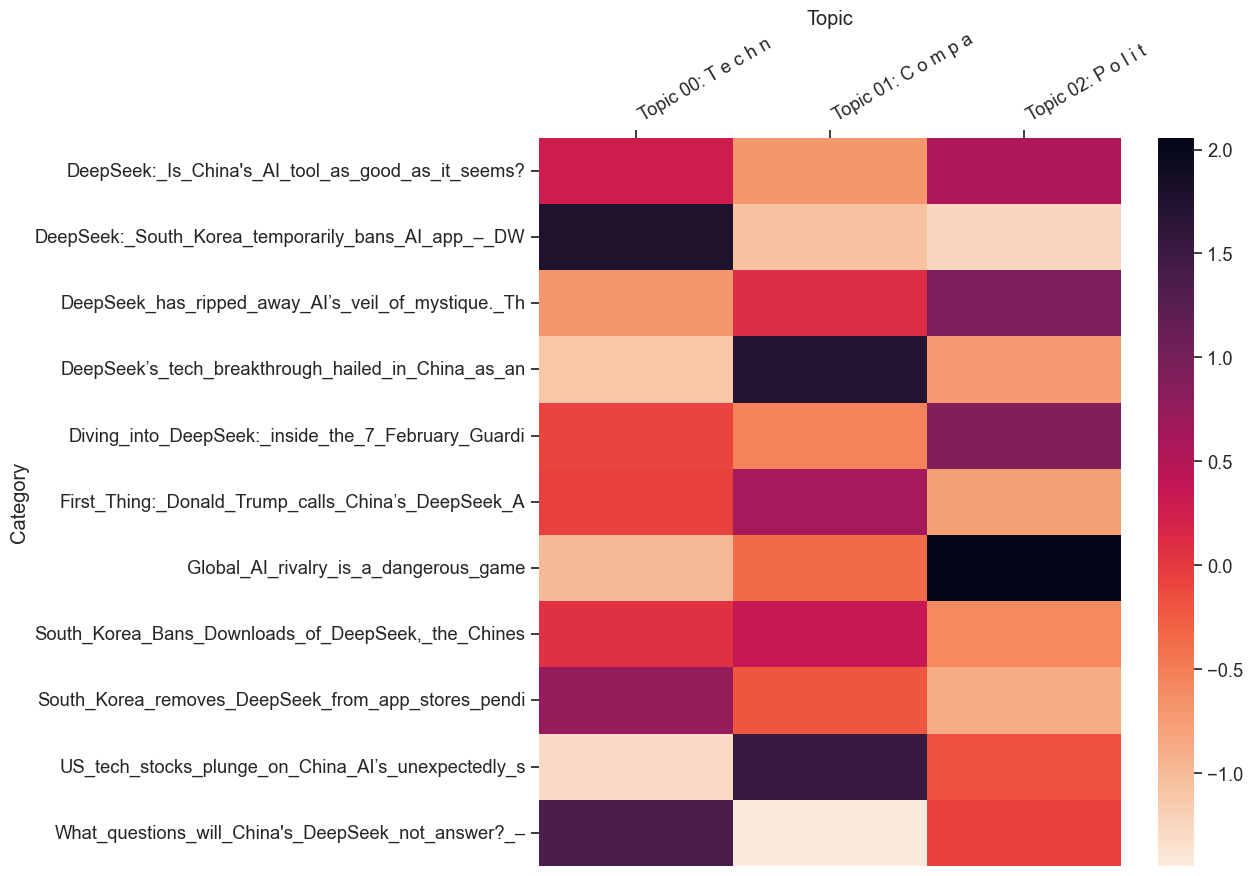

In [80]:
# Plot the heatmap
little_mallet_wrapper.plot_categories_by_topics_heatmap(
    titles,
    topic_distributions,
    manual_labels,
    target_labels=target_labels,
    dim=(13, 9)
)

# Get the current figure and axes
fig = plt.gcf()
ax = plt.gca()


plt.close(fig)


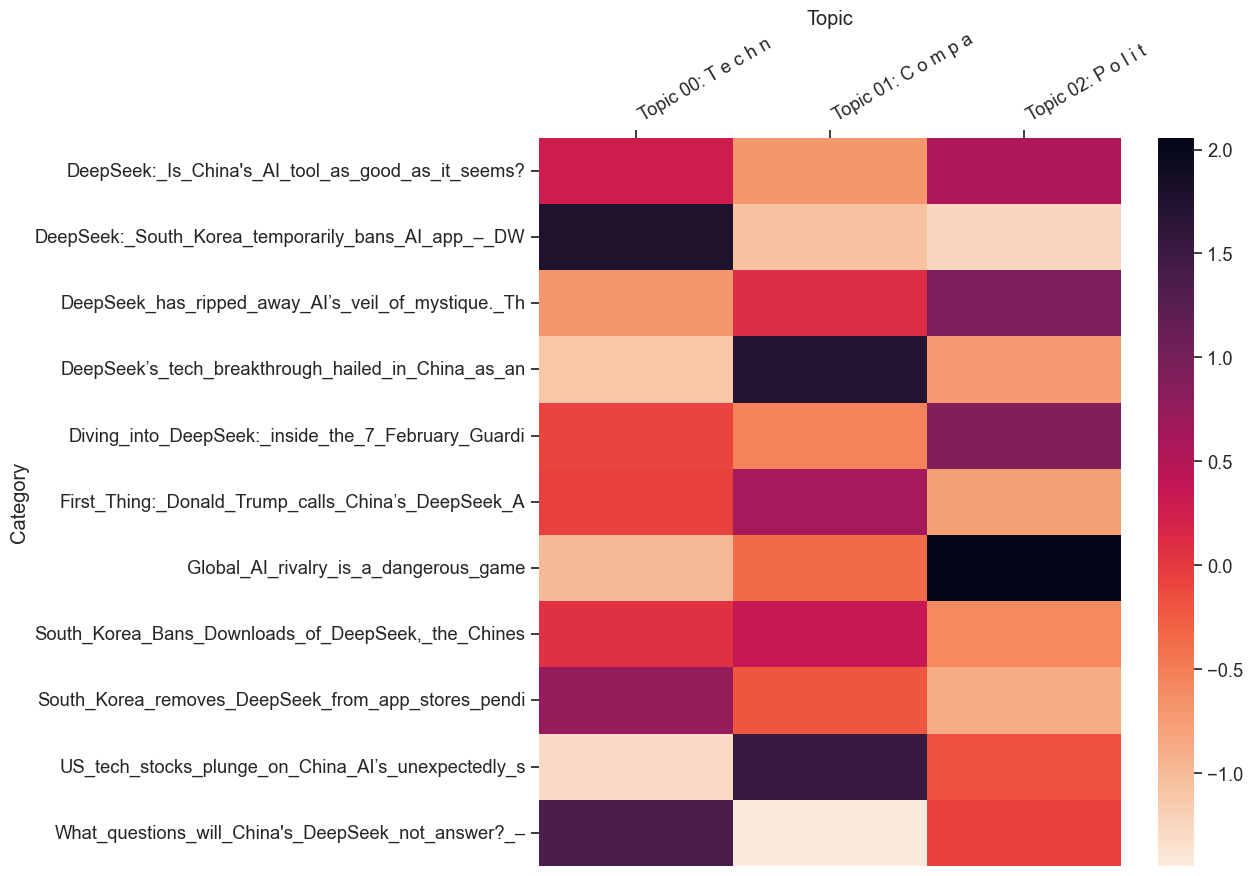

In [30]:

# Plot the heatmap
little_mallet_wrapper.plot_categories_by_topics_heatmap(
    titles,
    topic_distributions,
    manual_labels,
    target_labels=target_labels,
    dim=(13, 9)
)

# Get the current figure and axes
fig = plt.gcf()
ax = plt.gca()


plt.close(fig)


In [42]:
# make a random list of target labels
import random
target_labels = random.sample(titles, 10)

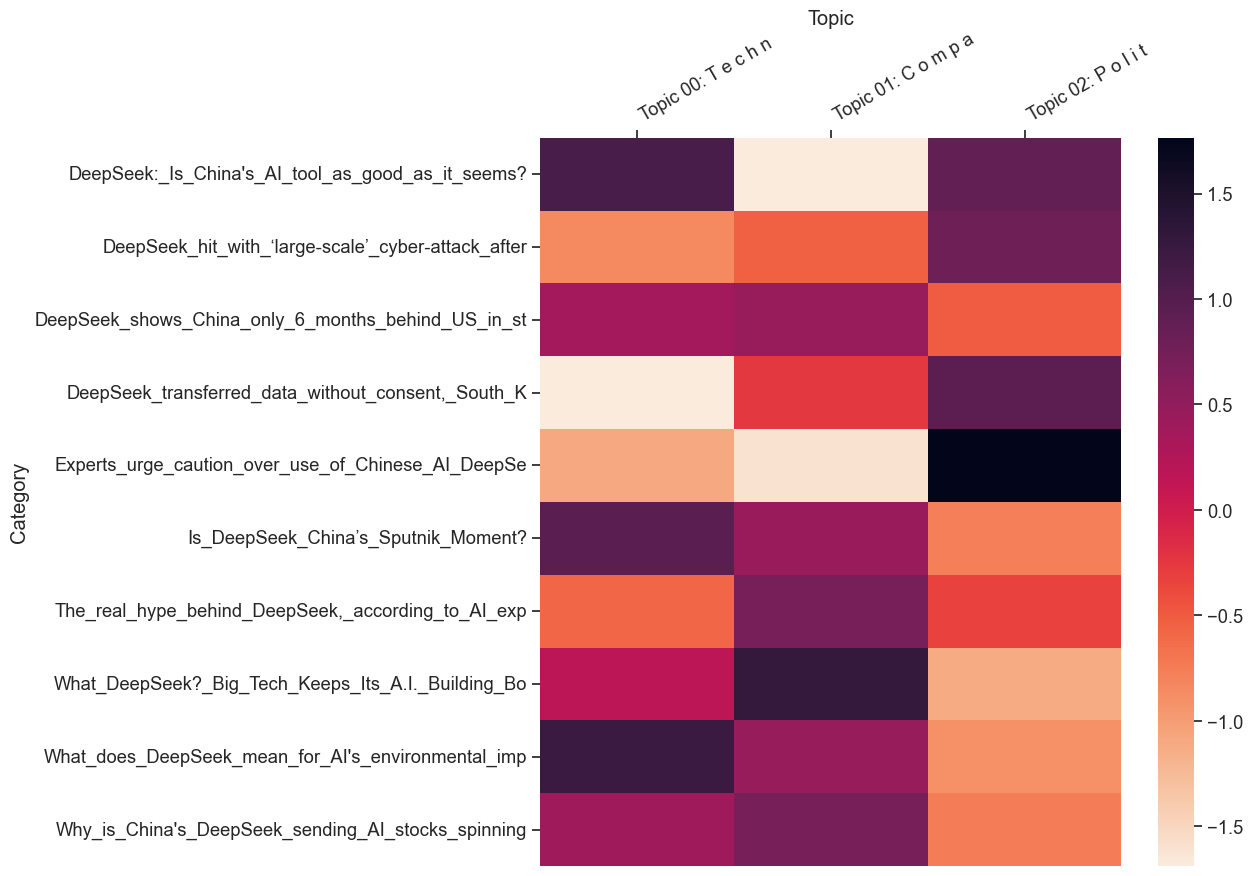

In [46]:
import matplotlib.pyplot as plt

little_mallet_wrapper.plot_categories_by_topics_heatmap(titles,
                                      topic_distributions,
                                      manual_labels, 
                                    
                                      target_labels=target_labels,
                                      dim= (13, 9)
                                     )


In [64]:
import os

# Clean negative titles: remove .txt and lowercase
negative_titles_clean = [os.path.splitext(name)[0].lower() for name in negative_titles]

# Clean the CSV document column: lowercase
all_df['document_clean'] = all_df['document'].str.lower()

# Filter
negative_topics_df = all_df[all_df['document_clean'].isin(negative_titles_clean)].reset_index(drop=True)

# Check
negative_topics_df


,document,Technology & AI Trends,Companies & Economy,Politics & Government,document_clean
0,Global_AI_rivalry_is_a_dangerous_game,0.267881,0.372664,0.359455,global_ai_rivalry_is_a_dangerous_game
1,What_questions_will_China's_DeepSeek_not_answe...,0.208035,0.702154,0.089811,what_questions_will_china's_deepseek_not_answe...
2,DeepSeek:_Is_China's_AI_tool_as_good_as_it_seems?,0.366400,0.378486,0.255115,deepseek:_is_china's_ai_tool_as_good_as_it_seems?
3,First_Thing:_Donald_Trump_calls_China’s_DeepSe...,0.374603,0.180784,0.444613,first_thing:_donald_trump_calls_china’s_deepse...
4,"South_Korea_Bans_Downloads_of_DeepSeek,_the_Ch...",0.438780,0.082390,0.478830,"south_korea_bans_downloads_of_deepseek,_the_ch..."
5,DeepSeek’s_tech_breakthrough_hailed_in_China_a...,0.223736,0.177627,0.598637,deepseek’s_tech_breakthrough_hailed_in_china_a...
6,DeepSeek_has_ripped_away_AI’s_veil_of_mystique...,0.251286,0.312889,0.435825,deepseek_has_ripped_away_ai’s_veil_of_mystique...
7,DeepSeek:_South_Korea_temporarily_bans_AI_app_...,0.666257,0.136314,0.197429,deepseek:_south_korea_temporarily_bans_ai_app_...
8,South_Korea_removes_DeepSeek_from_app_stores_p...,0.574910,0.105365,0.319725,south_korea_removes_deepseek_from_app_stores_p...
9,US_tech_stocks_plunge_on_China_AI’s_unexpected...,0.392114,0.119723,0.488163,us_tech_stocks_plunge_on_china_ai’s_unexpected...


In [ ]:
import matplotlib.pyplot as plt

little_mallet_wrapper.plot_categories_by_topics_heatmap(titles,
                                      topic_distributions,
                                      manual_labels, 
                                    
                                      target_labels=target_labels,
                                      dim= (13, 9)
                                     )


In [13]:
# Build the expected input for the heatmap function
dicts_to_plot = []
for title, label, topic_dist in zip(titles, target_labels, topic_distributions):
    for topic_idx, prob in enumerate(topic_dist):
        dicts_to_plot.append({
            'Category': label,
            'Topic': manual_labels[topic_idx],
            'Probability': prob
        })

df_to_plot = pd.DataFrame(dicts_to_plot)
print(df_to_plot.head())
# Now you can use df_to_plot for plotting or debugging.

                   Category                   Topic  Probability
0                       CNN  Technology & AI Trends     0.663080
1                       CNN     Companies & Economy     0.153869
2                       CNN   Politics & Government     0.183051
3  South China Morning Post  Technology & AI Trends     0.345897
4  South China Morning Post     Companies & Economy     0.290145


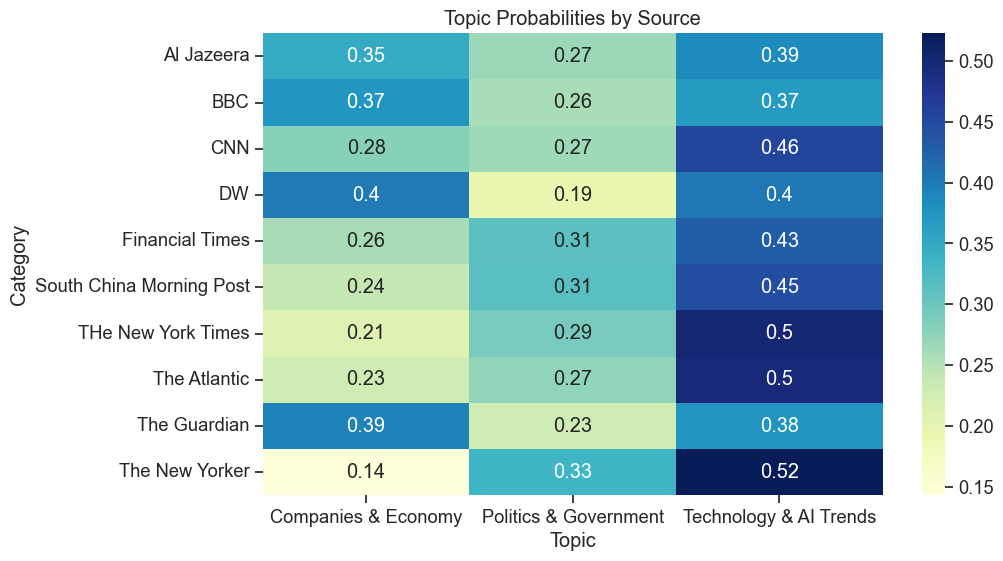

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pivot the DataFrame for heatmap
heatmap_data = df_to_plot.pivot_table(index='Category', columns='Topic', values='Probability')

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu')
plt.title('Topic Probabilities by Source')
plt.show()

This code demonstrates how to visualize topic distributions of articles grouped by their source. The heatmap summarizes multiple articles per source, allowing us to compare the average probability of each topic across different sources.